<a href="https://colab.research.google.com/github/giuliafazzi/adversarial-attacks/blob/main/Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adversarial Attacks**

## **Setup environment**

### **Import libraries**

In [1]:
from torchvision import models
import torch
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
import torch.nn as nn


from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

## **Define function**

In [53]:
def show(image):
  # img = image.detach()
  # img = to_pil_image(img)
  # plt.imshow(np.asarray(img))
  plt.imshow(img)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

## **Image Classifier**

In [63]:
class ResNet50:
  def __init__(self, train = False):
    self.weights = models.ResNet50_Weights.DEFAULT
    self.model = models.resnet50(weights=self.weights)
    self.set_device()

    if not train:
      self.eval_model()

  def set_device(self):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

  def preprocess(self, image):
    preprocess = self.weights.transforms(antialias=True)
    # preprocess = transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.CenterCrop(224),
    #     transforms.ToTensor(),
    # ])

    return preprocess(image)

  def eval_model(self):
    self.model.eval()

  def predict(self, image, preprocess = True, k = 5):
    if preprocess:
      image = self.preprocess(image).unsqueeze(0)

    output = self.model(image)
    prediction = output.squeeze(0).softmax(0)

    k_probs, k_ids = torch.topk(prediction, k)

    for conf, cat_id in zip(k_probs, k_ids):
      print(f'Confidence {conf:.2%}\tCategory: {self.weights.meta["categories"][cat_id]}')

    return image, output, k_probs, k_ids, self.model

## **FGSM (Fast Gradient Sign Method)**

$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$

adv_x : Adversarial image.

x : Original input image.

y : Original input label.

$\epsilon$ : Multiplier to ensure the perturbations are small.

$\theta$ : Model parameters.

$J$ : Loss.

In [52]:
def fgsm(image, model, label, epsilon):
  image.requires_grad = True
  x = model(image)
  loss = nn.CrossEntropyLoss()(x, torch.tensor([label]))

  model.zero_grad()
  loss.backward()

  data_grad = image.grad.data.sign()

  perturbation = epsilon * data_grad

  adversarial_image = image + perturbation

  return adversarial_image.detach()

## **Testing**

In [74]:
resnet = ResNet50()

In [95]:
img = Image.open("data/cat.jpg").convert("RGB")

In [96]:
batch, output, k_probs, k_ids, model = resnet.predict(img)

Confidence 39.01%	Category: tabby
Confidence 12.68%	Category: Egyptian cat
Confidence 6.48%	Category: tiger cat
Confidence 0.30%	Category: lynx
Confidence 0.16%	Category: washbasin


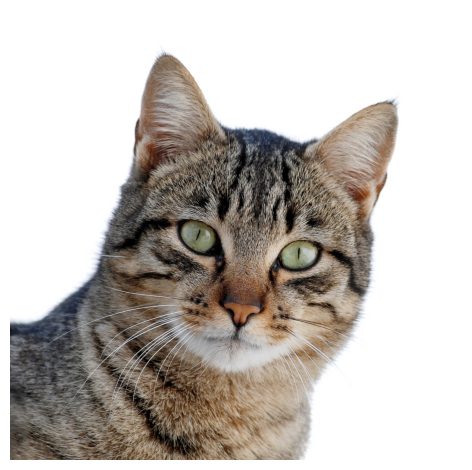

In [97]:
show(img)

In [104]:
adv_image = fgsm(image=batch, model=model, label=k_ids[0], epsilon=1)

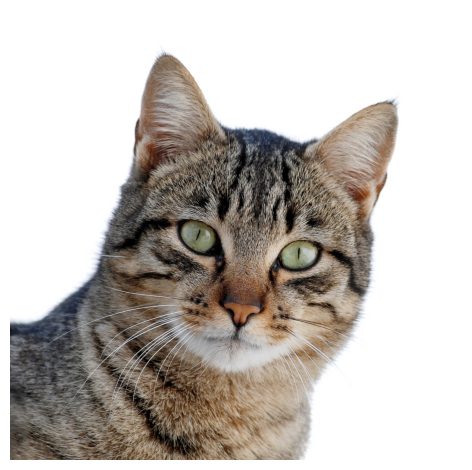

In [105]:
show(adv_image)

In [106]:
batch, output, k_probs, k_ids, model = resnet.predict(adv_image, preprocess = False)

Confidence 5.74%	Category: Christmas stocking
Confidence 4.00%	Category: envelope
Confidence 2.03%	Category: spider web
Confidence 2.00%	Category: cowboy boot
Confidence 1.47%	Category: book jacket
